In [255]:
import scipy
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

from numba import jit
from scipy.fft import fft2, fftshift
from skimage import img_as_float
from skimage.filters import window
from scipy.fft import fftn, ifftn
from scipy.ndimage import convolve
from skimage.restoration.uft import laplacian

from ormir_xct.segmentation.ipl_seg import ipl_seg
from ormir_xct.util.scanco_rescale import *
from ormir_xct.autocontour.autocontour import autocontour

In [183]:
image = sitk.ReadImage('D:\\OneDrive - University of Calgary\\DYNACT2\\models\\DYNACT2_214\\DYNACT2_214_HRpQCT\\stack_reg_output\\FULL_IMAGE.nii')
peri = sitk.ReadImage('D:\\OneDrive - University of Calgary\\DYNACT2\\models\\DYNACT2_214\\DYNACT2_214_HRpQCT\\stack_reg_output\\FULL_IMAGE_MASK.nii')

image_np = sitk.GetArrayFromImage(image)
peri_np = sitk.GetArrayFromImage(peri)

## IPL Standard Segmentation (seg_gauss)

In [187]:
masked = sitk.Mask(image, peri)
ipl_mask = ipl_seg(masked, 1170, 10000)
ipl_mask_np = sitk.GetArrayFromImage(ipl_mask)

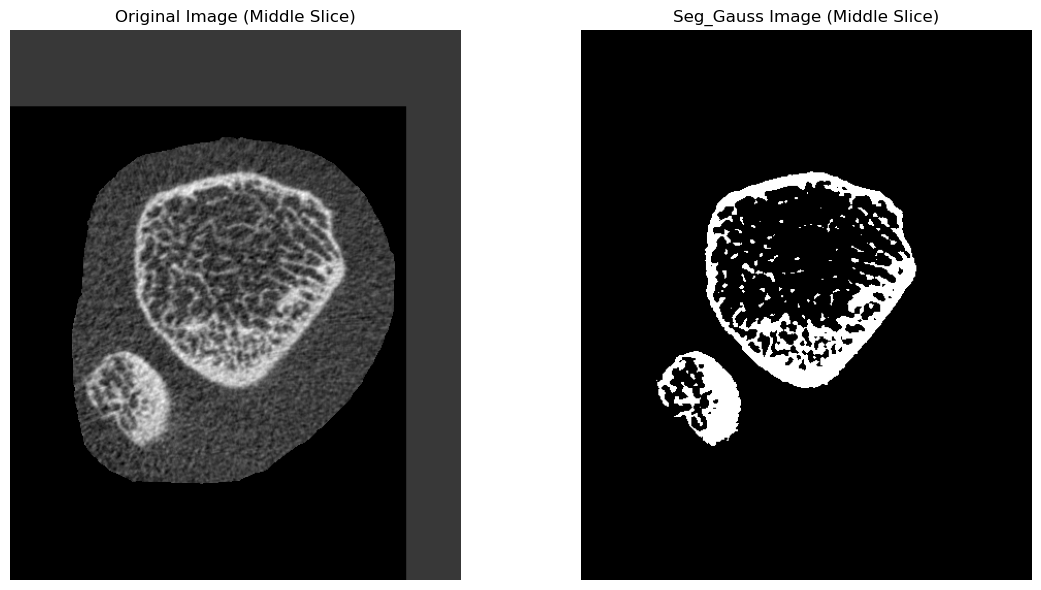

In [188]:
slice_index = image_np.shape[0] // 2

plt.figure(figsize=(12, 6))

# Plot the original image slice
plt.subplot(1, 2, 1)
plt.imshow(image_np[slice_index, :, :], cmap="gray")
plt.title("Original Image (Middle Slice)")
plt.axis("off")

# Plot the filtered image slice
plt.subplot(1, 2, 2)
plt.imshow(ipl_mask_np[slice_index, :, :], cmap="gray")
plt.title("Seg_Gauss Image (Middle Slice)")
plt.axis("off")

plt.tight_layout()
plt.show()

## Laplace Hamming

In [254]:
image = sitk.ReadImage('C:\\Users\\micha\\Desktop\\knee.nii')

image_np = sitk.GetArrayFromImage(image)

ipl_mask = ipl_seg(image, 1170, 10000)
ipl_mask_np = sitk.GetArrayFromImage(ipl_mask)

In [265]:
# Precompute the Laplacian filter once outside the function
def compute_laplacian_filter(shape):
    kx = np.fft.fftfreq(shape[0])[:, None, None]
    ky = np.fft.fftfreq(shape[1])[None, :, None]
    kz = np.fft.fftfreq(shape[2])[None, None, :]
    return -(kx**2 + ky**2 + kz**2)

@jit(nopython=True)
def apply_hamming_window(frequency_domain, cutoff_ratio, amplitude):
    """Apply a 3D Hamming window in the frequency domain with specified cutoff and amplitude."""
    shape = frequency_domain.shape
    hamming_x = np.hamming(shape[0]) * amplitude
    hamming_y = np.hamming(shape[1]) * amplitude
    hamming_z = np.hamming(shape[2]) * amplitude

    # Create a 3D Hamming filter by broadcasting
    hamming_3d = hamming_x[:, None, None] * hamming_y[None, :, None] * hamming_z[None, None, :]

    # Compute normalized distance and apply cutoff ratio in-place
    center_x, center_y, center_z = shape[0] // 2, shape[1] // 2, shape[2] // 2
    max_distance = np.sqrt(center_x**2 + center_y**2 + center_z**2)
    for x in range(shape[0]):
        for y in range(shape[1]):
            for z in range(shape[2]):
                distance = np.sqrt((x - center_x)**2 + (y - center_y)**2 + (z - center_z)**2)
                if distance / max_distance > cutoff_ratio:
                    hamming_3d[x, y, z] = 0

    # Apply the Hamming window to the frequency domain in-place
    frequency_domain *= hamming_3d
    return frequency_domain

# Precompute the Laplacian filter (in the function to avoid state issues in multithreaded calls)
laplacian_filter = None

def fft_laplace_hamming(image_np, laplace_epsilon=0.5, lp_cut_off_freq=0.3, hamming_amp=1.0):
    """
    Apply FFT Laplace Hamming filter for segmentation based on zero crossing of second derivative.
    
    Parameters:
    - image_path (str): Path to the 3D CT image file.
    - laplace_epsilon (float): Weight of the curvature image; higher values result in more edge-enhancement.
    - lp_cut_off_freq (float): Low-pass cutoff frequency of the Hamming filter (0 to 0.5).
    - hamming_amp (float): Amplitude of the Hamming filter.
    
    Returns:
    - filtered_image_np (ndarray): The result of applying the FFT Laplace Hamming filter.
    """
    global laplacian_filter  # Use a global variable to avoid recomputation

    # Step 2: Perform a 3D Fourier transform and shift to center zero frequency
    frequency_domain = np.fft.fftn(image_np)
    frequency_domain_shifted = np.fft.fftshift(frequency_domain)

    # Step 3: Apply the Hamming window in the frequency domain
    frequency_domain_shifted = apply_hamming_window(frequency_domain_shifted, lp_cut_off_freq, hamming_amp)

    # Step 4: Apply Laplacian filter in the frequency domain for edge enhancement
    if laplacian_filter is None or laplacian_filter.shape != frequency_domain_shifted.shape:
        laplacian_filter = compute_laplacian_filter(frequency_domain_shifted.shape)
    frequency_domain_laplace = frequency_domain_shifted * laplacian_filter * laplace_epsilon
    frequency_domain_combined = frequency_domain_shifted + frequency_domain_laplace

    # Step 5: Reconstruct the final filtered image by adding weighted original image
    frequency_domain_unshifted = np.fft.ifftshift(frequency_domain_combined)
    curvature_image_np = np.abs(np.fft.ifftn(frequency_domain_unshifted))

    # Combine curvature image with original image with variable weight
    final_image_np = (1 - laplace_epsilon) * image_np + curvature_image_np

    return final_image_np

In [266]:
filtered_image_np = fft_laplace_hamming(image_np, 0.45, 0.3, 1.0)

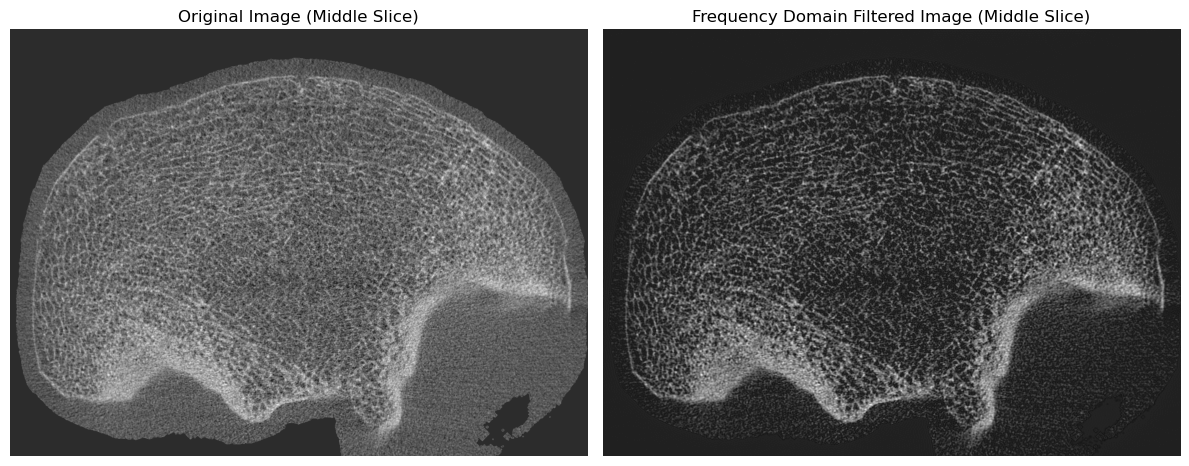

In [267]:
slice_index = image_np.shape[0] // 2

plt.figure(figsize=(12, 6))

# Plot the original image slice
plt.subplot(1, 2, 1)
plt.imshow(image_np[slice_index, :, :], cmap="gray")
plt.title("Original Image (Middle Slice)")
plt.axis("off")

# Plot the filtered image slice
plt.subplot(1, 2, 2)
plt.imshow(filtered_image_np[slice_index, :, :], cmap="gray")
plt.title("Frequency Domain Filtered Image (Middle Slice)")
plt.axis("off")

plt.tight_layout()
plt.show()

## Segmentation of Laplace_Hamming Filtered Image

In [268]:
im = sitk.GetImageFromArray(filtered_image_np)
# im = convert_scanco_to_linear_attenuation(im, 8192)
im.SetOrigin(image.GetOrigin())
im.SetDirection(image.GetDirection())
im.SetSpacing(image.GetSpacing())
# masked = sitk.Mask(im, peri)

seg = sitk.BinaryThreshold(im, 1170, 10000, 1, 0)
seg_np = sitk.GetArrayFromImage(seg)
sitk.WriteImage(seg, 'C:\\Users\\micha\\Desktop\\image_lh_seg.nii')

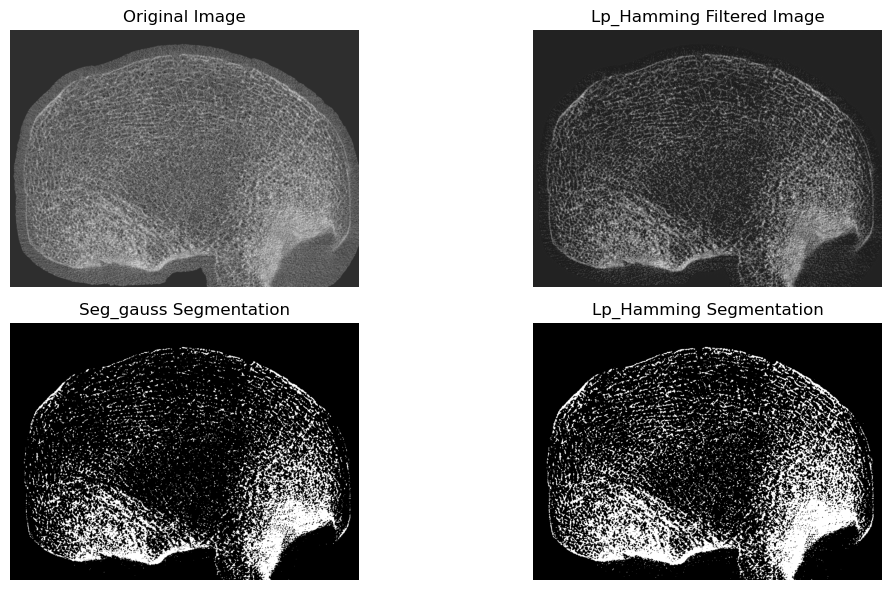

In [269]:
slice_index = (image_np.shape[0] // 2)-25

plt.figure(figsize=(12, 6))

# Plot the original image slice
plt.subplot(2, 2, 1)
plt.imshow(image_np[slice_index, :, :], cmap="gray")
plt.title("Original Image")
plt.axis("off")

# Plot the seg_gauss image
plt.subplot(2, 2, 2)
plt.imshow(filtered_image_np[slice_index, :, :], cmap="gray")
plt.title("Lp_Hamming Filtered Image")
plt.axis("off")

# Plot the filtered image slice
plt.subplot(2, 2, 3)
plt.imshow(ipl_mask_np[slice_index, :, :], cmap="gray")
plt.title("Seg_gauss Segmentation")
plt.axis("off")

# Plot the seg of lp_hamming
plt.subplot(2, 2, 4)
plt.imshow(seg_np[slice_index, :, :], cmap="gray")
plt.title("Lp_Hamming Segmentation")
plt.axis("off")

plt.tight_layout()
plt.show()